<a href="https://colab.research.google.com/github/santiagoprado12/Tesis/blob/main/pre_procesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# make sure to install these packages before running:
#!pip install pandas
!pip install sodapy
##
##
import pandas as pd
from sodapy import Socrata
 
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("www.datos.gov.co", None)
 
# Example authenticated client (needed for non-public datasets):
# client = Socrata(www.datos.gov.co,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")
 
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("gt2j-8ykr",limit=2100000) 
 
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [2]:
import datetime 
import numpy as np

In [3]:
print(pd.isnull(results_df["fecha_diagnostico"]).values.ravel().sum())#Cuantos NA hay en la columna de fecha de diagnóstico
 
results_df["fecha_diagnostico"]=results_df["fecha_diagnostico"].fillna(method="ffill")#rellenar con el ultimo valor diferente de NAN

4283


In [4]:
results_df["muerte/recuperacion"]=results_df["fecha_recuperado"] #Creando una columna Muertos/Recuperados donde se pone la fecha de recuperado o en su defecto la de muerte
results_df["muerte/recuperacion"].fillna(results_df["fecha_muerte"], inplace=True) #Rellenar valores faltantes con las fechas de fallecimientos
results_df["muerte/recuperacion"]=results_df["muerte/recuperacion"].fillna(method="ffill")#rellenar con el ultimo valor diferente de NAN

In [ ]:
results_df["Fecha_diag_date_fmat"]=[datetime.datetime.strptime(str(x),"%d/%m/%Y %H:%M:%S") for x in results_df["fecha_diagnostico"]]#Creando una nueva columna formato datetime
results_df["Fecha_M/R_date_fmat"]=[datetime.datetime.strptime(str(x),"%d/%m/%Y %H:%M:%S") for x in results_df["muerte/recuperacion"]]#Creando una nueva columna formato datetime

In [28]:
muertes=results_df[pd.notnull(results_df["fecha_muerte"])]["fecha_muerte"]
muertes_date_fmat=[datetime.datetime.strptime(str(x),"%d/%m/%Y %H:%M:%S") for x in muertes]#Creando una nueva columna formato datetime
df_muertes_date_fmat=pd.DataFrame({'muertes': muertes_date_fmat})

In [7]:
results_df.head()

,fecha_reporte_web,id_de_caso,fecha_de_notificaci_n,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,fuente_tipo_contagio,ubicacion,estado,pais_viajo_1_cod,pais_viajo_1_nom,recuperado,fecha_inicio_sintomas,fecha_diagnostico,fecha_recuperado,tipo_recuperacion,per_etn_,nom_grupo_,fecha_muerte,muerte/recuperacion,Fecha_diag_date_fmat,Fecha_M/R_date_fmat
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,Importado,Casa,Leve,380,ITALIA,Recuperado,27/2/2020 0:00:00,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6,NaN,NaN,13/3/2020 0:00:00,2020-03-06,2020-03-13
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,Importado,Casa,Leve,724,ESPAÑA,Recuperado,4/3/2020 0:00:00,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5,NaN,NaN,19/3/2020 0:00:00,2020-03-09,2020-03-19
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,Importado,Casa,Leve,724,ESPAÑA,Recuperado,29/2/2020 0:00:00,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6,NaN,NaN,15/3/2020 0:00:00,2020-03-09,2020-03-15
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,6/3/2020 0:00:00,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6,NaN,NaN,26/3/2020 0:00:00,2020-03-11,2020-03-26
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,8/3/2020 0:00:00,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6,NaN,NaN,23/3/2020 0:00:00,2020-03-11,2020-03-23


In [10]:
def ta_todo(f):
    e=results_df[(results_df["Fecha_diag_date_fmat"]<f) & (f<results_df["Fecha_M/R_date_fmat"])].shape[0]
    r=results_df[(results_df["Fecha_M/R_date_fmat"]<f) & pd.isnull(results_df["fecha_muerte"])].shape[0]
    fa=results_df[(results_df["Fecha_M/R_date_fmat"]<f) & ~pd.isnull(results_df["fecha_muerte"])].shape[0]
    mr=results_df[results_df["Fecha_M/R_date_fmat"]<f].shape[0]
    ar=results_df[(results_df["Fecha_diag_date_fmat"]<f)].shape[0]
    return e, r, fa, mr, ar

In [11]:
fecha_mayor=str(results_df["fecha_de_notificaci_n"].unique()[-1])
fecha_mayor1=datetime.datetime.strptime(str(fecha_mayor),"%d/%m/%Y %H:%M:%S")

In [12]:
c=str(results_df["fecha_de_notificaci_n"][0])
c1=datetime.datetime.strptime(c,"%d/%m/%Y %H:%M:%S")
c2=[c1]
i=1
while c2[-1] != fecha_mayor1:
    c2.append(c2[0]+datetime.timedelta(days=i))
    i+=1

In [13]:
casos_diarios={}
casos_diarios["fechas"]=c2
casos_diarios_DF=pd.DataFrame(data=casos_diarios)

In [ ]:
casos_diarios_DF.tail()

In [ ]:
a=np.array(list(map(ta_todo, casos_diarios_DF["fechas"])))

In [ ]:
casos_diarios_DF["activos_diarios"]=list(a[:,0])
casos_diarios_DF["recuperados_diarios"]=list(a[:,1])
casos_diarios_DF["fallecidos_diarios"]=list(a[:,3])
casos_diarios_DF["acumulado diarios"]=list(a[:,4])

In [ ]:
#casos_diarios_DF["comprobacion"]=list(map(lambda x, y, z: x+y==z, casos_diarios_DF["recuperados_diarios"],casos_diarios_DF["fallecidos_diarios"],casos_diarios_DF["m/r_diarios"]))

In [ ]:
#sum(~casos_diarios_DF["comprobacion"])

In [34]:
casos_diarios_DF["casos diarios"]=list(map(lambda f: (results_df[results_df["Fecha_diag_date_fmat"]==f].shape[0]), casos_diarios_DF["fechas"]))
#casos_diarios_DF["fallecidos por dia"]=list(map(lambda f: (results_df[results_df["Fecha_muerte"]==f].shape[0]), casos_diarios_DF["fechas"]))
#casos_diarios_DF["recuperados por dia"]=list(map(lambda f: (results_df[results_df["Fecha_diag_date_fmat"]==f].shape[0]), casos_diarios_DF["fechas"]))

In [29]:
casos_diarios_DF["fallecidos por dia"]=list(map(lambda f: (df_muertes_date_fmat[df_muertes_date_fmat['muertes']==f].shape[0]), casos_diarios_DF["fechas"]))

In [ ]:
#results_df[results_df["Fecha_diag_date_fmat"]==casos_diarios_DF["fechas"][300]].shape

In [ ]:
casos_diarios_DF

In [32]:
import matplotlib.pyplot as plt

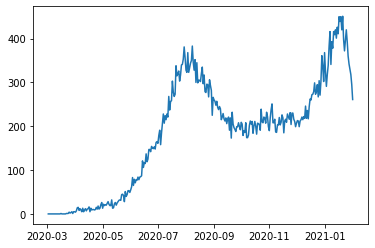

In [33]:
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["fallecidos por dia"])

In [ ]:
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["activos_diarios"])

In [ ]:
casos_diarios_DF["acumulado diarios"]=list(map(lambda f: results_df[(results_df["Fecha_diag_date_fmat"]<f)], casos_diarios_DF["fechas"]))
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["acumulado diarios"])
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["recuperados_diarios"])
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["fallecidos_diarios"])

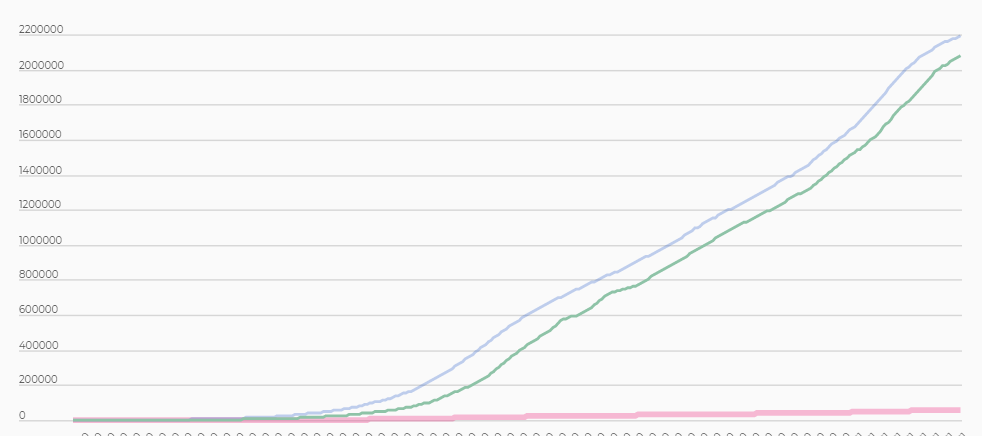

In [ ]:
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["casos diarios"])

In [ ]:
casos_diarios_DF["casos diarios"].max()

In [ ]:
casos_diarios_DF["casos diarios 7 dias"] = casos_diarios_DF["casos diarios"].rolling(7, min_periods=1).mean()

In [ ]:
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["casos diarios"])
plt.plot(casos_diarios_DF["fechas"],casos_diarios_DF["casos diarios 7 dias"],linewidth=5)

In [ ]:
data=plt.hist(results_df["fecha_reporte_web"],bins=len(results_df["fecha_reporte_web"].unique())-1)

In [36]:
dataFrameAux={}
dataFrameAux["enfermos dias"]=data[0]
dataFrameAux_DF=pd.DataFrame(data=dataFrameAux)
dataFrameAux_DF["enfermos dias media 7 dias"] = dataFrameAux_DF["enfermos dias"].rolling(7, min_periods=1).mean()

In [ ]:
plt.plot(dataFrameAux_DF["enfermos dias"],)
plt.plot(dataFrameAux_DF["enfermos dias media 7 dias"], linewidth=5)

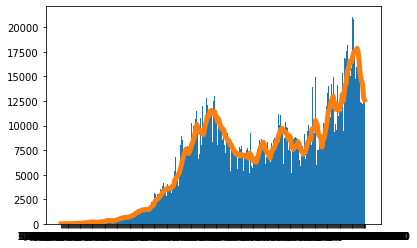

In [37]:
data=plt.hist(results_df["fecha_reporte_web"],bins=len(results_df["fecha_reporte_web"].unique())-1)
plt.plot(dataFrameAux_DF["enfermos dias media 7 dias"], linewidth=5)

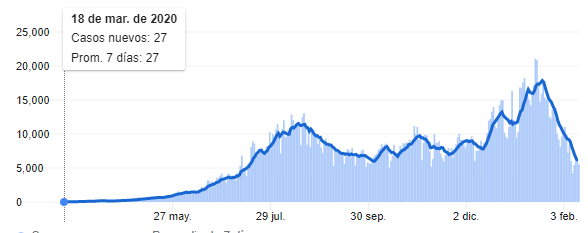

In [ ]:
dataR=plt.hist(results_df[pd.notna(results_df["fecha_recuperado"])]["fecha_recuperado"],bins=len(results_df[pd.notna(results_df["fecha_recuperado"])]["fecha_recuperado"].unique())-1)

In [ ]:
dataFrameAuxR={}
dataFrameAuxR["recuperados dias"]=dataR[0]
dataFrameAuxR_DF=pd.DataFrame(data=dataFrameAuxR)
dataFrameAuxR_DF["recuperados dias media 7 dias"] = dataFrameAuxR_DF["recuperados dias"].rolling(7, min_periods=1).mean()

In [ ]:
dataR=plt.hist(results_df[pd.notna(results_df["fecha_recuperado"])]["fecha_recuperado"],bins=len(results_df[pd.notna(results_df["fecha_recuperado"])]["fecha_recuperado"].unique())-1)
plt.plot(dataFrameAuxR_DF["recuperados dias media 7 dias"], linewidth=5)

In [ ]:
dataM=plt.hist(results_df[pd.notna(results_df["fecha_muerte"])]["fecha_muerte"],bins=len(results_df[pd.notna(results_df["fecha_muerte"])]["fecha_muerte"].unique())-1)

In [ ]:
dataFrameAuxM={}
dataFrameAuxM["muertos dias"]=dataM[0]
dataFrameAuxM_DF=pd.DataFrame(data=dataFrameAuxM)
dataFrameAuxM_DF["muertos dias media 7 dias"] = dataFrameAuxM_DF["muertos dias"].rolling(7, min_periods=1).mean()

In [ ]:
dataM=plt.hist(results_df[pd.notna(results_df["fecha_muerte"])]["fecha_muerte"],bins=len(results_df[pd.notna(results_df["fecha_muerte"])]["fecha_muerte"].unique())-1)
plt.plot(dataFrameAuxM_DF["muertos dias media 7 dias"], linewidth=5)

In [ ]:
dataM=plt.hist(results_df[pd.notna(results_df["fecha_muerte"])]["fecha_reporte_web"],bins=len(results_df[pd.notna(results_df["fecha_muerte"])]["fecha_reporte_web"].unique())-1)